In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
dir = os.getcwd()

In [21]:
df = pd.read_csv(dir+'/data/merged.csv')

In [22]:
#날짜를 인덱스로 설정
df.set_index('date', inplace=True)
df.index = pd.to_datetime(df.index)
df1 = df.copy().dropna() #결측치 제거

#문자로 된 자료 숫자로 바꿔주기
for a in df1.columns:
    df1[a] = df1[a].astype('float')
    

In [23]:
#장단기 스프레드 // 출하지수-재고지수 스프레드
df1['y_spd'] = df1['10y'] - df1['3y']
df1['manu_spd'] = df1['shipment'] - df1['inven']
df1['manu_ratio'] = (df1['shipment'] / df1['inven'])-1 #스프레드하면 스케일이 약간 애매해져서, 양 지수에 로그취해서 빼줌

In [24]:
#설비투자전망지수 대기업+중소기업 평균 산출
df1['bsi_inv'] = (df1['bsi_inv_big'] + df1['bsi_inv_small']) / 2

In [25]:
df1.columns

Index(['bsi_inv_big', 'bsi_inv_small', '3y', '10y', 'shipment', 'inven', 'ipi',
       'employ', 'durable', 'wti', 'dubai', 'iron', 'copper', 'gold', 'y_spd',
       'manu_spd', 'manu_ratio', 'bsi_inv'],
      dtype='object')

In [26]:
#필요없는거 제거
df2 = df1.drop(columns=['bsi_inv_big', 'bsi_inv_small','10y', '3y', 'shipment', 'inven',
                        'wti','iron', 'copper', 'gold'])

In [27]:
#샘플기간 분리: 기준일 2017-07-01부터 out of sample
df2_train = df2['2003-02-01':'2017-06-01']
df2_test = df2['2017-07-01':]

### 국면 판단 과정
매 시점 반복 시행

1. t시점까지의 자료 표준화
2. PCA 수행
3. Growth indicator 산정
4. AR(1)으로 t+1시점 fitted value 추정

### In-sample 기간 CF 사이클

In [62]:
df2.index

DatetimeIndex(['2003-02-01', '2003-03-01', '2003-04-01', '2003-05-01',
               '2003-06-01', '2003-07-01', '2003-08-01', '2003-09-01',
               '2003-10-01', '2003-11-01',
               ...
               '2024-09-01', '2024-10-01', '2024-11-01', '2024-12-01',
               '2025-01-01', '2025-02-01', '2025-03-01', '2025-04-01',
               '2025-05-01', '2025-06-01'],
              dtype='datetime64[ns]', name='date', length=269, freq=None)

In [63]:
# t 시점의 growth indicator 예측하려고 함
# t-1 시점을 지정
time = df2_test.index[0] + pd.DateOffset(months=-1) 

In [64]:
#샘플기간 시작일부터 t-1시점까지의 데이터 사용
temp = df2['2003-02-01':time]

In [65]:
x_list = ['employ', 'durable', 'dubai', 'y_spd', 'manu_spd', 'bsi_inv']

In [66]:
temp = temp[x_list]

In [67]:
temp

,employ,durable,dubai,y_spd,manu_spd,bsi_inv
date,,,,,,
2003-02-01,59.6,37.2,30.20,0.420,12.570,98.5
2003-03-01,59.5,36.4,27.52,0.420,12.150,95.0
2003-04-01,59.2,36.3,23.56,0.430,10.827,89.0
2003-05-01,59.2,35.9,24.32,0.410,10.881,91.0
2003-06-01,59.2,34.5,25.67,0.390,12.022,88.5
...,...,...,...,...,...,...
2017-02-01,60.8,82.4,54.30,0.498,11.609,93.5
2017-03-01,60.9,82.7,51.02,0.512,13.381,95.5
2017-04-01,60.8,84.1,52.55,0.504,11.168,98.0


In [68]:
from sklearn.preprocessing import StandardScaler
#PCA 함수: 데이터프레임을 인풋으로
#PCA 결과들을 리스트에 모아서 리턴해줌

def pca(x):
    '''
    데이터프레임을 인풋으로
    PCA 결과들을 딕셔너리에 모아서 리턴해줌
    딕셔너리 키 목록
    1. df_scaled: 표준화된 데이터
    2. cov_matrix: 표준화된 데이터의 공분산 행렬
    3. eigenvalues_df: eigenvalues
    4. eigenvectors_df: eigenvectors
    5. explained_variance_ratio_df: 분산 설명비율
    '''
    scaler = StandardScaler() # standard normal
    df_scaled = scaler.fit_transform(x) #데이터 표준화
    cov_matrix = np.cov(df_scaled, rowvar=False) #공분산 행렬 계산
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix) #아이겐벡터, 밸류 계산
    principal_components = df_scaled.dot(eigenvectors[:, 0])  # 첫 번째 주성분(PC1)

    # PC1 방향을 나타내는 벡터
    pc1_vector = eigenvectors[:, 0]

    #Explained Variance Ratio
    explained_variance_ratio = eigenvalues / np.sum(eigenvalues)

    #PCA 결과 저장
    index = []
    for i in range(0,len(x.columns)):
        index.append(f'PC{i+1}')

    cov_matrix_df = pd.DataFrame(cov_matrix, columns=x.columns, index=x.columns)
    eigenvalues_df = pd.DataFrame({'Eigenvalues': eigenvalues}, index=index)
    eigenvectors_df = pd.DataFrame(eigenvectors, columns=index,
                                index=x.columns)
    explained_variance_ratio_df = pd.DataFrame({'Explained Variance Ratio': explained_variance_ratio},
                                            index=index)
    result = {'df_scaled' : df_scaled,
              'cov_matrix' : cov_matrix,
              'eigenvalues' : eigenvalues_df,
              'eigenvectors' : eigenvectors_df,
              'explained_variance' : explained_variance_ratio_df}
    print(result.keys())
    return result

In [69]:
pca_result = pca(temp) #PCA 진행

dict_keys(['df_scaled', 'cov_matrix', 'eigenvalues', 'eigenvectors', 'explained_variance'])


In [70]:
pca_result['explained_variance'] #분산기여도 확인

,Explained Variance Ratio
PC1,0.378100
PC2,0.281669
PC3,0.165482
PC4,0.097004
PC5,0.032189
PC6,0.045557


In [71]:
#pca1의 주성분을 PC1, PC2, PC3로 설정
#표준화된 X 랑 eigenvector 곱하기
data_pc = pca_result['df_scaled']@pca_result['eigenvectors'][['PC1', 'PC2', 'PC3']]

In [72]:
# 변동 설명력 기준으로 가중 선정해서 지수 산출 vs 동일가중 산출
data_pc['growth_indicator'] = data_pc['PC1'] + data_pc['PC2'] + data_pc['PC3']

In [73]:
data_pc

,PC1,PC2,PC3,growth_indicator
0,0.210103,-1.073777,-1.455777,-2.319451
1,0.445232,-1.554950,-1.265342,-2.375060
2,0.810774,-2.425195,-0.800921,-2.415341
3,0.660436,-2.191102,-0.970154,-2.500820
4,0.701002,-2.398183,-0.927822,-2.625003
...,...,...,...,...
168,2.189377,0.579268,0.905226,3.673871
169,1.951258,0.794795,0.711118,3.457171
170,1.943546,1.023714,0.707615,3.674875
171,2.285253,0.771250,0.905479,3.961981


In [74]:
data_pc.index = temp.index

In [75]:
data_pc

,PC1,PC2,PC3,growth_indicator
date,,,,
2003-02-01,0.210103,-1.073777,-1.455777,-2.319451
2003-03-01,0.445232,-1.554950,-1.265342,-2.375060
2003-04-01,0.810774,-2.425195,-0.800921,-2.415341
2003-05-01,0.660436,-2.191102,-0.970154,-2.500820
2003-06-01,0.701002,-2.398183,-0.927822,-2.625003
...,...,...,...,...
2017-02-01,2.189377,0.579268,0.905226,3.673871
2017-03-01,1.951258,0.794795,0.711118,3.457171
2017-04-01,1.943546,1.023714,0.707615,3.674875


In [76]:
data_pc['cycle'], data_pc['trend'] = sm.tsa.filters.cffilter(
    data_pc['growth_indicator'], low=18, high=96, drift=True
    )

<Axes: xlabel='date'>

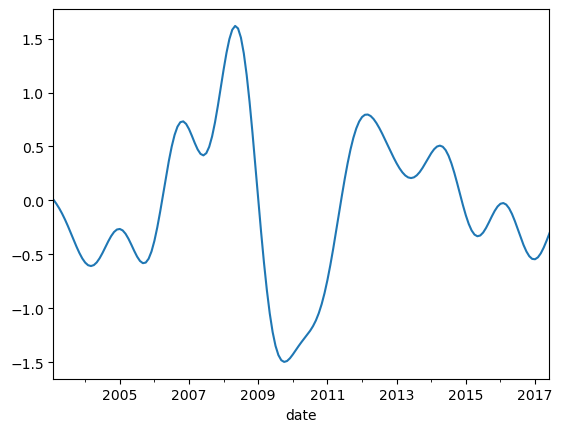

In [77]:
data_pc['cycle'].plot()

In [46]:
data_pc['cycle'].iloc[-1]

np.float64(-0.30337561630650156)

In [49]:
dates = [] #결과저장: 날짜
filtered = [] #결과저장: 예측된 growth indicator
x_list = ['employ', 'durable', 'dubai', 'y_spd', 'manu_spd', 'bsi_inv'] #대상 변수 바꾸고싶으면 이 부분 수정

for i in range(0,len(df2_test.index)):
    time = df2_test.index[i] # 예측값 얻고 싶은 날짜
    temp = df2['2003-02-01':time] # 데이터셋 이름 바뀌면 이 부분 수정
    temp = temp[x_list] #분석 대상 변수들 -> df2에서 가져옴
    pca_result = pca(temp) #PCA 진행

    #pca1의 주성분을 PC1, PC2, PC3로 설정
    #표준화된 X 랑 eigenvector 곱하기
    data_pc = pca_result['df_scaled']@pca_result['eigenvectors'][['PC1', 'PC2', 'PC3']]

    # Growth indicator 산출하는 부분
    # 각 지표별 가중치 변경하려면 이 부분 수정하기

    data_pc['growth_indicator'] = data_pc['PC1'] + data_pc['PC2'] + data_pc['PC3']
    data_pc['cycle'], data_pc['trend'] = sm.tsa.filters.cffilter(
    data_pc['growth_indicator'], low=18, high=96, drift=True
    )
    dates.append(time)
    filtered.append(data_pc['cycle'].iloc[-1])
    


dict_keys(['df_scaled', 'cov_matrix', 'eigenvalues', 'eigenvectors', 'explained_variance'])
dict_keys(['df_scaled', 'cov_matrix', 'eigenvalues', 'eigenvectors', 'explained_variance'])
dict_keys(['df_scaled', 'cov_matrix', 'eigenvalues', 'eigenvectors', 'explained_variance'])
dict_keys(['df_scaled', 'cov_matrix', 'eigenvalues', 'eigenvectors', 'explained_variance'])
dict_keys(['df_scaled', 'cov_matrix', 'eigenvalues', 'eigenvectors', 'explained_variance'])
dict_keys(['df_scaled', 'cov_matrix', 'eigenvalues', 'eigenvectors', 'explained_variance'])
dict_keys(['df_scaled', 'cov_matrix', 'eigenvalues', 'eigenvectors', 'explained_variance'])
dict_keys(['df_scaled', 'cov_matrix', 'eigenvalues', 'eigenvectors', 'explained_variance'])
dict_keys(['df_scaled', 'cov_matrix', 'eigenvalues', 'eigenvectors', 'explained_variance'])
dict_keys(['df_scaled', 'cov_matrix', 'eigenvalues', 'eigenvectors', 'explained_variance'])
dict_keys(['df_scaled', 'cov_matrix', 'eigenvalues', 'eigenvectors', 'explained_

In [50]:
dates

[Timestamp('2017-07-01 00:00:00'),
 Timestamp('2017-08-01 00:00:00'),
 Timestamp('2017-09-01 00:00:00'),
 Timestamp('2017-10-01 00:00:00'),
 Timestamp('2017-11-01 00:00:00'),
 Timestamp('2017-12-01 00:00:00'),
 Timestamp('2018-01-01 00:00:00'),
 Timestamp('2018-02-01 00:00:00'),
 Timestamp('2018-03-01 00:00:00'),
 Timestamp('2018-04-01 00:00:00'),
 Timestamp('2018-05-01 00:00:00'),
 Timestamp('2018-06-01 00:00:00'),
 Timestamp('2018-07-01 00:00:00'),
 Timestamp('2018-08-01 00:00:00'),
 Timestamp('2018-09-01 00:00:00'),
 Timestamp('2018-10-01 00:00:00'),
 Timestamp('2018-11-01 00:00:00'),
 Timestamp('2018-12-01 00:00:00'),
 Timestamp('2019-01-01 00:00:00'),
 Timestamp('2019-02-01 00:00:00'),
 Timestamp('2019-03-01 00:00:00'),
 Timestamp('2019-04-01 00:00:00'),
 Timestamp('2019-05-01 00:00:00'),
 Timestamp('2019-06-01 00:00:00'),
 Timestamp('2019-07-01 00:00:00'),
 Timestamp('2019-08-01 00:00:00'),
 Timestamp('2019-09-01 00:00:00'),
 Timestamp('2019-10-01 00:00:00'),
 Timestamp('2019-11-

In [51]:
growth_filtered = pd.DataFrame({'date': dates, 'growth_indicator': filtered})
growth_filtered.set_index('date', inplace=True)

<Axes: xlabel='date'>

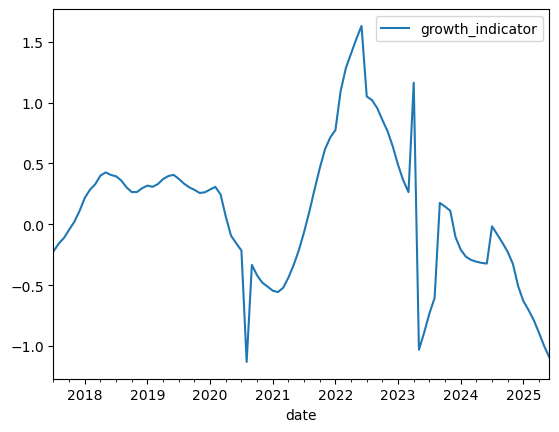

In [52]:
growth_filtered.plot()

In [79]:
example = pd.concat([data_pc['cycle'], growth_filtered['growth_indicator']])

<Axes: xlabel='date'>

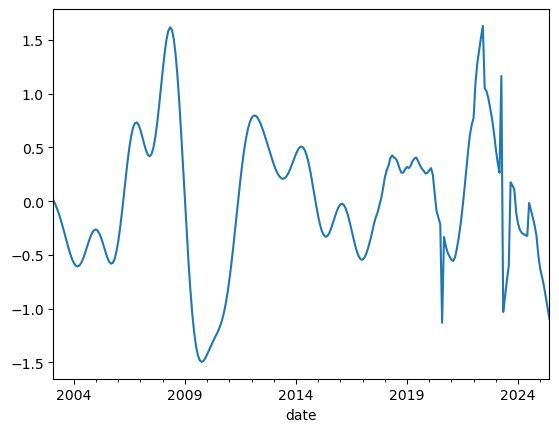

In [80]:
example.plot()

Text(0.5, 1.0, '추세 판단 결과')

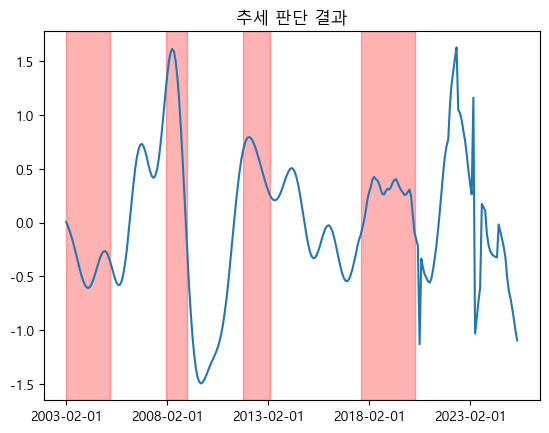

In [84]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False 
date = example.index
y = example

fig, ax1 = plt.subplots()
ax1.plot(date, y)
ax1.axvspan('2003-02-01', '2005-04-01', color='red', alpha=0.3)
ax1.axvspan('2008-01-01', '2009-02-01', color='red', alpha=0.3)
ax1.axvspan('2011-11-01', '2013-03-01', color='red', alpha=0.3)
ax1.axvspan('2017-09-01', '2020-05-01', color='red', alpha=0.3)

plt.xticks(date[::60])
plt.title('추세 판단 결과')

In [61]:
data_pc

,PC1,PC2,PC3,growth_indicator,cycle,trend
0,-1.393744,-0.846188,0.562419,-1.677512,-0.065025,-1.612487
1,-1.241599,-1.374872,0.461940,-2.154531,-0.206534,-1.960207
2,-0.998065,-2.289271,0.384452,-2.902884,-0.351171,-2.576134
3,-1.095090,-2.000108,0.489665,-2.605533,-0.495642,-2.146522
4,-1.009340,-2.244337,0.289786,-2.963891,-0.636526,-2.376206
...,...,...,...,...,...,...
264,3.425842,-0.141257,-0.716711,2.567874,-0.595614,-0.060081
265,3.017608,-0.090146,-0.839753,2.087708,-0.752710,-0.395360
266,2.903827,-0.258955,-0.951564,1.693308,-0.891693,-0.662989
267,2.781010,-0.550524,-0.732208,1.498279,-1.007131,-0.754790


In [59]:
df2['2003-02-01':'2017-06-01'].index

DatetimeIndex(['2003-02-01', '2003-03-01', '2003-04-01', '2003-05-01',
               '2003-06-01', '2003-07-01', '2003-08-01', '2003-09-01',
               '2003-10-01', '2003-11-01',
               ...
               '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01'],
              dtype='datetime64[ns]', name='date', length=173, freq=None)